#### Simple PPO Agent (CityLearn)

In [ ]:
# Basic imports & versions
import sys, os, json, time, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [20]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10

In [ ]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity'], drop_predictions=False)

env = CityLearnEnv(schema, central_agent=True) # create env
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_15-46-12'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 6
Electrical storage capacity: {'Building_1': 4.0, 'Building_2': 4.0, 'Building_3': 3.3, 'Building_4': 3.3, 'Building_5': 4.0, 'Building_6': 3.3}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (6,), float32)]
Number of Observations: 85


#### Build & Train PPO

In [ ]:
# old:
# env = Monitor(CityLearnPPOWrapper(env))

from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

log_dir = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
os.makedirs(log_dir, exist_ok=True)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = Monitor(train_env, filename=os.path.join(log_dir, "monitor.csv"))
logger = PPOTrainLogger()
TOTAL_TIMESTEPS = 2208 * 40

model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=0, # seed for pseudo random generators
    device='cpu', # ppo is intended to run on cpu
    #learning_rate=3e-4,
    verbose=1,
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save("ppo_01")  # saving the model to ppo_01.zip 

Using cpu device
Wrapping the env in a DummyVecEnv.
Total time elapsed for 88320 steps: 0.00 minutes


### Quick Evaluation

In [23]:
eval_env = CityLearnEnv(schema, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)

model = PPO.load("ppo_01")  # loading the model from ppo_01.zip             


#eval_returns = evaluate(model, eval_env, episodes=EVAL_EPISODES)
#print(f'Eval mean return over {EVAL_EPISODES} ep(s):', eval_returns.mean())

#if hasattr(logger, 'step_df'): logger.step_df.to_csv('train_steps.csv', index=False)
#if hasattr(logger, 'ep_df'): logger.ep_df.to_csv('episode_returns.csv', index=False) 
                    

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_15-46-14'


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [24]:
# Enhanced evaluation: timings, episode length, per-step stats, deterministic toggle.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False):
    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    t_global_start = time.time()
    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            #print(f"Action taken: {action}")
            action_list.append(action)
            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            step_rewards.append(float(r))
            ep_len += 1
            if render:
                env.render()
        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.array(action_list))
        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'actions': np.array(action_list),
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)
        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")
        print("KPIs:", kpis)
    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)
    return metrics_df, np.array(all_step_rewards), all_kpis

# Deterministic
#metrics_det, step_rewards_det, kpis_det = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=True)

# Stochastic
metrics_stoch, step_rewards_stoch, kpis_stoch = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=False)

Action taken: [-0.92215693 -0.42389566 -1.          0.14682409 -0.12220056 -0.58161724]
Action taken: [ 0.18316367 -0.55048025  0.92152554 -0.73302406  1.          0.8658002 ]
Action taken: [ 1.         -0.7146454  -0.49594238  0.12896916  0.09985314 -0.40535975]
Action taken: [ 0.35298443 -1.         -0.83714736  0.31191307 -0.8168023   0.725059  ]
Action taken: [-0.3431644   0.62917423  0.56909096 -0.2824878   0.03670996 -1.        ]
Action taken: [ 0.22128388  0.5363674   0.41395587  1.         -0.8468688   0.8479312 ]
Action taken: [-0.76703054  1.         -0.700345    1.          0.37087408 -0.28043512]
Action taken: [ 0.24198128  0.5590619  -0.8374139   0.5671052  -1.         -0.28008974]
Action taken: [-1.          0.21108304 -0.67901117 -0.5438863   1.         -1.        ]
Action taken: [ 0.8931635 -0.4703983 -0.4246577  1.         0.257079  -1.       ]
Action taken: [-0.5366138   0.5020545  -0.253618   -0.45997378 -1.         -1.        ]
Action taken: [ 0.2289062  -1.        

,episode,return,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,wall_time_s
0,1,-1731.975083,2207,-0.784764,-4.367783,0.0,0.657652,13.406387,164.623025
1,2,-1741.606409,2207,-0.789128,-4.509664,0.0,0.653980,13.491832,163.580454
2,3,-1734.408326,2207,-0.785867,-4.653892,0.0,0.659172,13.439551,164.216792
3,4,-1735.169274,2207,-0.786212,-5.520362,0.0,0.662653,13.396396,164.745805
4,5,-1739.511608,2207,-0.788179,-5.350564,0.0,0.669947,13.465858,163.895977
5,6,-1736.244666,2207,-0.786699,-5.658915,0.0,0.663174,13.517025,163.275578
6,7,-1732.772305,2207,-0.785126,-5.051974,0.0,0.667990,13.500498,163.475457
7,8,-1729.181880,2207,-0.783499,-4.766918,0.0,0.661824,13.487423,163.633933
8,9,-1738.314980,2207,-0.787637,-5.308476,0.0,0.664763,13.247760,166.594197
9,10,-1737.991828,2207,-0.787491,-5.506530,0.0,0.671823,13.478873,163.737723


### Plots

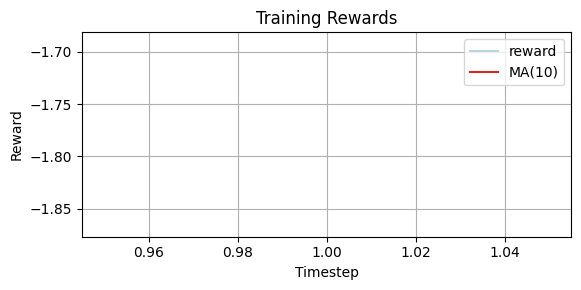

In [25]:
import pandas as pd
if hasattr(logger, 'step_df'):
    step_df = logger.step_df.copy()
    if not step_df.empty:
        # Reward moving average
        window = min(1000, max(10, len(step_df)//20))
        step_df['reward_ma'] = step_df['reward'].rolling(window, min_periods=1).mean()
        plt.figure(figsize=(6,3))
        plt.plot(step_df['timestep'], step_df['reward'], alpha=0.3, label='reward')
        plt.plot(step_df['timestep'], step_df['reward_ma'], color='C3', label=f'MA({window})')
        plt.xlabel('Timestep'); plt.ylabel('Reward'); plt.title('Training Rewards'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    plt.figure(figsize=(5,3))
    plt.plot(ep_df['episode'], ep_df['return'], marker='o')
    plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Episode Returns'); plt.grid(True); plt.tight_layout(); plt.show()

### Next Ideas
- Add VecNormalize for observation/reward normalization.
- Add EvalCallback for periodic evaluation.
- Tune hyperparameters (n_steps, batch_size, gamma).
- Switch reward function (ComfortReward etc.).
- Multi-building or multi-agent variants.